In [676]:
%matplotlib inline
from pylab import *


from esn.esn_discrete import ESN_discrete as ESN

# root-mean-square error
def rmse(y, y_pred): 
    return sqrt( mean((y-y_pred)**2) );


We use **ESN_discrete** class as it were a DMP.

<img src="esn/esn_discrete.png" width=500>

* **ESN_discrete.imitate_path(path)** runs the regression.

* **ESN_discrete.rollout()** produces a trajectory with the learned weights.


Class of trajectories:

$
y = g x + a (1-t) sin(6\pi t) 
$

where $g$ is the goal, $a$ is the amplitude of the sinusoidal component, s is the starting point

* 3 training trajectories 
    * s = 0
    * g = 1.0, 0.8, 0.6
    * a = 0.00, 0.10, 0.20
* 3 test trajectories 
    * s = 0
    * g = 0.9, 0.7, 0.5
    * a = 0.05, 0.15, 0.25

(-0.1, 1.2)

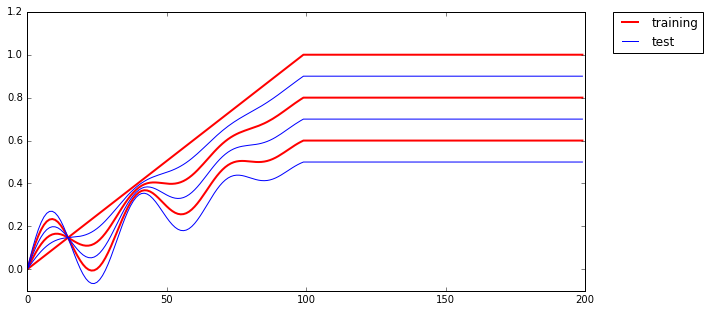

In [677]:
x = linspace(0,1,100)

Gy = [1.0, 0.8, 0.6]
Sy = [0.0, 0.1, 0.2]
Gt = [0.9, 0.7, 0.5]
St = [0.05, 0.15, 0.25]

Y=[]
for k in xrange(len(Gy)) :
    y = Gy[k]*x + Sy[k]*sin(6*pi*x)*(1-x)
    y = hstack([y,Gy[k]*ones(100)])
    Y.append(y)
    
T=[]
for k in xrange(len(Gt)) :
    y = Gt[k]*x + St[k]*sin(6*pi*x)*(1-x)
    y = hstack([y,Gt[k]*ones(100)])
    T.append(y)
    
samples = len(Y)
tests = len(T)

fig = figure(figsize=(10,5))
p1,_,_ =plot(array(Y).T, c="red", lw=2, label="training")
p2,_,_ =plot(array(T).T, c="blue", label="test")
legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ylim(-0.1,1.2)

### Initialize the echo-state network

In [678]:
sim = ESN(
    N       = 100,
    timesteps = 200,
    dt      = 0.001,
    tau     = 0.09,
    alpha   = 0.00801,
    beta    = 0.9999,
    epsilon = 1.0e-30,
    lmbd    = 1e-4
)


### Learning

Regression

In [679]:
# run the regression
sim.imitate_path(Y)

### Test
Reproducing the trajectories

In [680]:
# reproduce the training trajectories
Y_r = []
for k in xrange(samples) :  
    y_r = sim.rollout(y0=0.0, goal=Gy[k])
    Y_r.append(y_r)
    
# reproduce the test trajectories
T_r = []
for k in xrange(samples) :  
    t_r = sim.rollout(y0=0.0, goal=Gt[k])
    T_r.append(t_r)  

Computing the errors

In [681]:
Y_rmse = rmse ( array(Y).ravel(), array(Y_r).ravel())
pT_rmse = rmse ( array(T[:-2]).ravel(), array(T_r[:-2]).ravel())
T_rmse = rmse ( array(T).ravel(), array(T_r).ravel())
print "TRAINING RMSE: {}".format( Y_rmse )
print "INTERNAL TEST RMSE: {}".format( pT_rmse )
print "TEST RMSE: {}".format( T_rmse )


TRAINING RMSE: 0.00574820022827
INTERNAL TEST RMSE: 0.00685417762501
TEST RMSE: 0.0130735121805


Plotting the trajectories

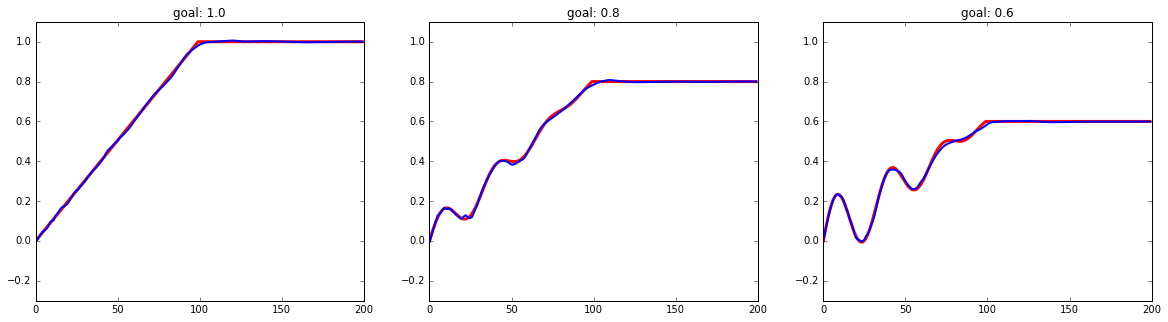

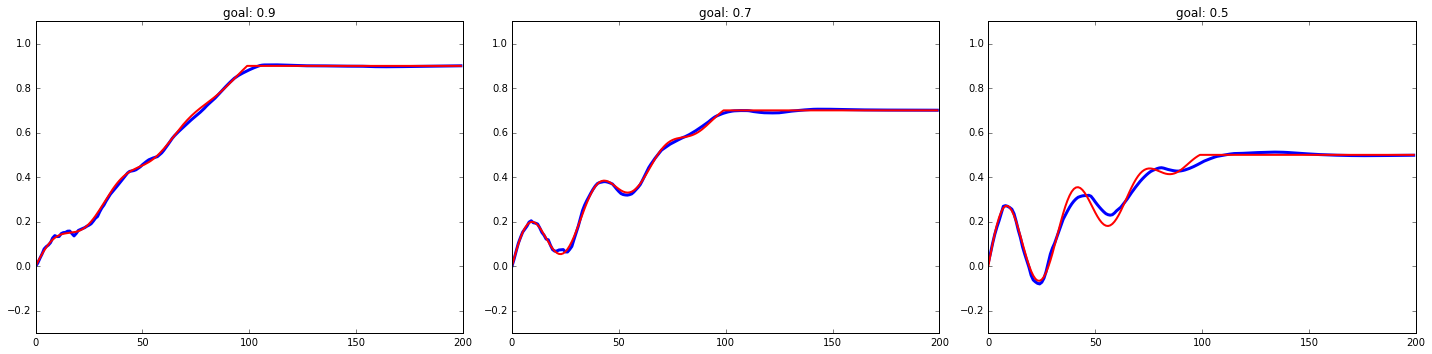

In [682]:
fig1 = figure(figsize=(20,5))
fig2 = figure(figsize=(20,5))
for k in xrange(samples) :  
    ax1 = fig1.add_subplot(1,samples,k+1)
    ax1.set_title("goal: {}".format(Gy[k]))
    ax1.plot(Y[k], c="red", lw=3)
    ax1.plot(Y_r[k], c="blue", lw=2)
    ax1.set_ylim([-.3,1.1])

for k in xrange(tests) :  
    ax2 = fig2.add_subplot(1,samples,k+1)
    ax2.set_title("goal: {}".format(Gt[k]))
    ax2.plot(T_r[k], c="blue", lw=3)
    ax2.plot(T[k], c="red", lw=2)
    ax2.set_ylim([-.3,1.1])
tight_layout()


Plotting the activity and the spectrogram of the network

(-25.28392424799798, 25.28392424799798)

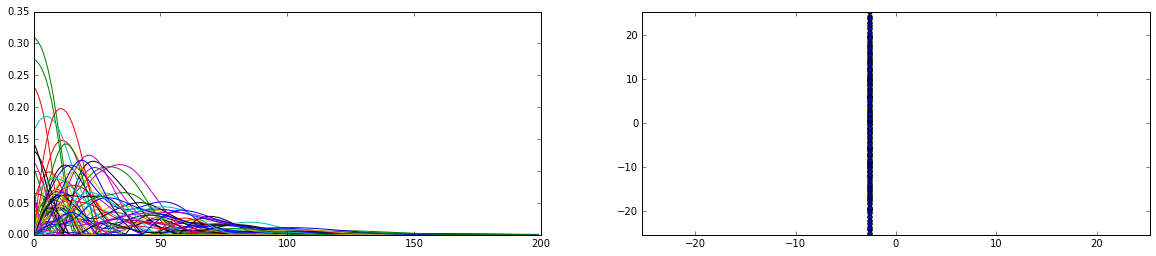

In [683]:
fig = figure(figsize=(20,4))
ax = fig.add_subplot(121)
x = sim.activations()
pl = ax.plot(x.T)
ax = fig.add_subplot(122)
l = eigvals(sim.res.w)
sr = max(abs(l))
sc = ax.scatter(real(l), imag(l))
ax.set_xlim([-sr,sr])
ax.set_ylim([-sr,sr])